# Interpretation of 3D CNNs for Brain MRI Data Classification


 Introduction
In this notebook we will explore how the model makes a decision on the example of simple 3D CNN classificationl model on pytorch. In the current notebook we use Alzheimer’s Disease Neuroimaging Initiative (ADNI) dataset *(ADNI is a global research effort that actively supports the investigation and development of treatments that slow or stop the progression of Alzheimer's disease (AD))* , preprocessed by the [Clinica](https://aramislab.paris.inria.fr/clinica/docs/public/latest/WhatIsClinica/) software platform.

Our goal will be to study various techniques for interpreting СNN models to test the reliability of neural networks in the case of MRI brain classification.


Proceesing with this notebook you confirm, that you have granted access to ADNI 1, 2, 3, GO Study Data. And your agreement on data terms and conditions.

The data accesed from the original sourse: https://ida.loni.usc.edu/pages/access/studyData.jsp?categoryId=14&subCategoryId=30



Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 9.1 MB/s 


In [3]:
import os
from os import path
import sys
import argparse
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.transforms as transforms
import abc
import logging
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



## Importing the data¶


Add a shortcut to your drive:

https://drive.google.com/drive/folders/1L2ry9r795_YmMnqT58t2-VpLAfGvylFw?usp=sharing

In [4]:
!cd drive/MyDrive/neuro_2021 && ls

 adni_seminar.zip   models	   'Untitled presentation.gslides'
 HCP_aging.gdoc     Seminar.ipynb


In [5]:
path_to_data = Path('drive/MyDrive/neuro_2021/adni_seminar.zip')
!unzip $path_to_data

Archive:  drive/MyDrive/neuro_2021/adni_seminar.zip
   creating: adni_with/
   creating: adni_with/sub-ADNI002S0685/
   creating: adni_with/sub-ADNI002S0685/ses-M00/
   creating: adni_with/sub-ADNI002S0685/ses-M00/deeplearning_prepare_data/
   creating: adni_with/sub-ADNI002S0685/ses-M00/deeplearning_prepare_data/image_based/
   creating: adni_with/sub-ADNI002S0685/ses-M00/deeplearning_prepare_data/image_based/t1_linear/
  inflating: adni_with/sub-ADNI002S0685/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0685_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt  
   creating: adni_with/sub-ADNI002S0685/ses-M00/t1_linear/
  inflating: adni_with/sub-ADNI002S0685/ses-M00/t1_linear/sub-ADNI002S0685_ses-M00_T1w_space-MNI152NLin2009cSym_res-1x1x1_affine.mat  
  inflating: adni_with/sub-ADNI002S0685/ses-M00/t1_linear/sub-ADNI002S0685_ses-M00_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz  
  inflating: adni_with/sub-ADNI002S0685/ses-M00/t1_linear/sub-ADNI0

In [6]:
!cd adni_seminar && ls

/bin/bash: line 0: cd: adni_seminar: No such file or directory


### Writing dataset

In [7]:
FILENAME_TYPE = {'full': '_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w',
                 'cropped': '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w',
                 'skull_stripped': '_space-Ixi549Space_desc-skullstripped_T1w',
                 'gm_maps': '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability',
                 'shepplogan': '_phantom-SheppLogan'}

class MRIDataset(Dataset):
    """Abstract class for all derived MRIDatasets."""

    def __init__(self, caps_directory, data_file,
                 preprocessing, transformations, labels,
                 augmentation_transformations=None, multi_cohort=False):
        self.caps_dict = self.create_caps_dict(caps_directory, multi_cohort)
        self.transformations = transformations
        self.augmentation_transformations = augmentation_transformations
        self.eval_mode = False
        self.labels = labels
        self.diagnosis_code = {
            'CN': 0,
            'BV': 1,
            'AD': 1,
            'sMCI': 0,
            'pMCI': 1,
            'MCI': 1,
            'unlabeled': -1}
        self.preprocessing = preprocessing

        if not hasattr(self, 'elem_index'):
            raise ValueError(
                "Child class of MRIDataset must set elem_index attribute.")
        if not hasattr(self, 'mode'):
            raise ValueError(
                "Child class of MRIDataset must set mode attribute.")

        # Check the format of the tsv file here
        if isinstance(data_file, str):
            self.df = pd.read_csv(data_file, sep='\t')
        elif isinstance(data_file, pd.DataFrame):
            self.df = data_file
        else:
            raise Exception('The argument data_file is not of correct type.')

        if not multi_cohort:
            self.df["cohort"] = "single"

        mandatory_col = {"participant_id", "session_id"}
        if self.labels:
            mandatory_col.add("diagnosis")
        if multi_cohort:
            mandatory_col.add("cohort")
        if self.elem_index == "mixed":
            mandatory_col.add("%s_id" % self.mode)

        if not mandatory_col.issubset(set(self.df.columns.values)):
            raise Exception("the data file is not in the correct format."
                            "Columns should include %s" % mandatory_col)

        unique_diagnoses = set(self.df.diagnosis)
        unique_codes = set()
        for diagnosis in unique_diagnoses:
            unique_codes.add(self.diagnosis_code[diagnosis])
        self.elem_per_image = self.num_elem_per_image()
        self.size = self[0]['image'].size()

    def __len__(self):
        return len(self.df) * self.elem_per_image

    @staticmethod
    def create_caps_dict(caps_directory, multi_cohort):
        caps_dict = {'single': caps_directory}
        return caps_dict

    def _get_path(self, participant, session, cohort, mode="image"):

        if cohort not in self.caps_dict.keys():
            raise ValueError('Cohort names in labels and CAPS definitions do not match.')

        image_path = path.join(self.caps_dict[cohort], participant, session,
                                   'deeplearning_prepare_data', '%s_based' % mode, 't1_linear',
                                   participant + '_' + session
                                   + FILENAME_TYPE['cropped'] + '.pt')

        return image_path

    def _get_meta_data(self, idx):
        image_idx = idx // self.elem_per_image
        participant = self.df.loc[image_idx, 'participant_id']
        session = self.df.loc[image_idx, 'session_id']
        cohort = self.df.loc[image_idx, 'cohort']

        if self.elem_index is None:
            elem_idx = idx % self.elem_per_image
        elif self.elem_index == "mixed":
            elem_idx = self.df.loc[image_idx, '%s_id' % self.mode]
        else:
            elem_idx = self.elem_index

        if self.labels:
            diagnosis = self.df.loc[image_idx, 'diagnosis']
            label = self.diagnosis_code[diagnosis]
        else:
            label = self.diagnosis_code['unlabeled']

        return participant, session, cohort, elem_idx, label

    def _get_full_image(self):

        participant_id = self.df.loc[0, 'participant_id']
        session_id = self.df.loc[0, 'session_id']
        cohort = self.df.loc[0, 'cohort']

        try:
            image_path = self._get_path(participant_id, session_id, cohort, mode="image")
            image = torch.load(image_path)
        except FileNotFoundError:
            image_path = get_nii_path(
                self.caps_dict,
                participant_id,
                session_id,
                cohort=cohort,
                preprocessing=self.preprocessing)
            image_nii = nib.load(image_path)
            image_np = image_nii.get_fdata()
            image = ToTensor()(image_np)

        return image

    @abc.abstractmethod
    def __getitem__(self, idx):
        pass

    @abc.abstractmethod
    def num_elem_per_image(self):
        pass

    def eval(self):
        self.eval_mode = True
        return self

    def train(self):
        self.eval_mode = False
        return self


class MRIDatasetImage(MRIDataset):
    """Dataset of MRI organized in a CAPS folder."""

    def __init__(self, caps_directory, data_df,
                 preprocessing='t1-linear', train_transformations=None,
                 labels=True, all_transformations=None, multi_cohort=False):
        """
        Args:
            caps_directory (string): Directory of all the images.
            data_file (string or DataFrame): Path to the tsv file or DataFrame containing the subject/session list.
            preprocessing (string): Defines the path to the data in CAPS.
            train_transformations (callable, optional): Optional transform to be applied only on training mode.
            labels (bool): If True the diagnosis will be extracted from the given DataFrame.
            all_transformations (callable, options): Optional transform to be applied during training and evaluation.
            multi_cohort (bool): If True caps_directory is the path to a TSV file linking cohort names and paths.
        """
        self.elem_index = None
        self.mode = "image"
        super().__init__(caps_directory, data_df, preprocessing,
                         augmentation_transformations=train_transformations, labels=labels,
                         transformations=all_transformations, multi_cohort=multi_cohort)

    def __getitem__(self, idx):
        participant, session, cohort, _, label = self._get_meta_data(idx)

        image_path = self._get_path(participant, session, cohort, "image")
        image = torch.load(image_path)

        if self.transformations:
            image = self.transformations(image)

        if self.augmentation_transformations and not self.eval_mode:
            image = self.augmentation_transformations(image)

        sample = {'image': image, 'label': label, 'participant_id': participant, 'session_id': session,
                  'image_path': image_path}

        return sample

    def num_elem_per_image(self):
        return 1

class MinMaxNormalization(object):
    """Normalizes a tensor between 0 and 1"""

    def __call__(self, image):
        return (image - image.min()) / (image.max() - image.min())

def get_transforms(mode, minmaxnormalization=True, data_augmentation=None):
    """
    Outputs the transformations that will be applied to the dataset
    :param mode: (str) input used by the network. Chosen from ['image', 'patch', 'roi', 'slice'].
    :param minmaxnormalization: (bool) if True will perform MinMaxNormalization
    :param data_augmentation: (list[str]) list of data augmentation performed on the training set.
    :return:
    - container transforms.Compose including transforms to apply in train and evaluation mode.
    - container transforms.Compose including transforms to apply in evaluation mode only.
    """
    augmentation_dict = {"None": None}
    if data_augmentation:
        augmentation_list = [augmentation_dict[augmentation] for augmentation in data_augmentation]
    else:
        augmentation_list = []

    if minmaxnormalization:
        transformations_list = [MinMaxNormalization()]
    else:
        transformations_list = []

    all_transformations = transforms.Compose(transformations_list)
    train_transformations = transforms.Compose(augmentation_list)

    return train_transformations, all_transformations

## Defining the model

In [8]:
class Conv5_FC3(nn.Module):
    """
    Classifier for a binary classification task
    Image level architecture used on Minimal preprocessing
    """
    def __init__(self, dropout=0.5):
        super(Conv5_FC3, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

        )

        self.classifier = nn.Sequential(
            Flatten(),
            nn.Dropout(p=0.5),

            nn.Linear(128 * 6 * 7 * 6, 1300),
            nn.ReLU(),

            nn.Linear(1300, 50),
            nn.ReLU(),

            nn.Linear(50, 2)

        )
        self.gradients = None
        self.flattened_shape = [-1, 128, 6, 7, 6]

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)
        x = self.classifier(x)

        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class PadMaxPool3d(nn.Module):
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(
            kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride -
                  f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output



### Interpretation methods

### Grad-Cam

The Idea: to take the gradients of the target class flowing into the final convolutional layer to produce a heatmap highlighting the important regions in the image to predict the concept.

1. Select the class of interest ( target class)
2. Сalculate the gradient  of the class logit nd the activation maps 
3. Average over activations using the global average pooling
4. Obtain he neuron importance weights  coefficients α k c for each map (this weight α c k represents a partial linearization of the deep network downstream from A, and captures the ‘importance’ of feature map k for a target class c)
5. Consider a linear combination
6. Apply ReLU
7. Interpolate the heat-map (increase the dimension)


In [51]:
class GradCam():
    def __init__(self, model):
        self.model = model

    def grad_cam(self, input, logit, size):
        logit[:, logit.data.max(1)[1]].backward() ## get the gradient of the output with respect to the parameters of the model
            #             logit[:,0].backward()
        activation = self.model.get_activations(input).detach() # get the activations of the last convolutional layer
        act_grad = self.model.get_activations_gradient() # pull the gradients out of the model
        pool_act_grad = torch.mean(act_grad, dim=[2, 3, 4], keepdim=True) # pool the gradients across the channels  
        activation = activation * pool_act_grad # weight the channels by corresponding gradients
        heatmap = torch.sum(activation, dim=1) #
        heatmap = F.relu(heatmap) # relu on top of the heatmap
        heatmap /= torch.max(heatmap) # normalize the heatmap
        heatmap = F.interpolate(heatmap.unsqueeze(0), size[1:], mode='trilinear', align_corners=False)  # 58 70 58 interpolate the heat-map and project it onto the original image
        return heatmap

In [67]:
def get_masks(model, loader, mean_mask = True, mask_type='grad_cam', size=(180, 180, 180), save = None, save_binary=None, task='AD_CN'):
    masks = []
    labels = []
    output_dir = '/output'
    mask_dir = os.path.join(output_dir, 'img_mask')
    os.makedirs(mask_dir, exist_ok=True)
    for i, data in tqdm(enumerate(loader, 0)):
        image = data['image'].cuda()
        labels.append(data['label'].numpy().item())
        logit = model(image)
        if mask_type == 'grad_cam':
            gc = GradCam(model)
            heatmap = gc.grad_cam(image, logit, size)
            masks.append(heatmap.cpu().numpy())
            name = data['image_path'][0][-80:-53]
            if save:
                nib.save(nib.Nifti1Image(heatmap.cpu().numpy(), affine=np.eye(4)),
                     os.path.join(mask_dir, '{}_gradcam_mask.nii.gz'.format(name)))
            if save_binary:
                mask_binary_dir = os.path.join(output_dir, 'img_mask_binary')
                os.makedirs(mask_binary_dir, exist_ok=True)
                binary = heatmap.cpu().numpy()[heatmap.cpu().numpy() <= 0.35] = 0
                nib.save(nib.Nifti1Image(binary, affine=np.eye(4)),
                         os.path.join(mask_binary_dir, '{}_gradcam_mask.nii.gz'.format(name)))
            del image, heatmap
        elif mask_type == 'guided_backprop':
            gp = GuidedBackprop(model)
            pred = logit.data.max(1)[1].item()
            img_grad = gp.guided_backprop(image, pred)
            masks.append(img_grad)
            del image, img_grad, pred
        elif mask_type == 'mean_pertrub':
            mp = MeanPertrub(rep=9)
            pred = logit.data.max(1)[1].item()
            for param in model.parameters():
                param.requires_grad = False
            masks_pertrub = mp.get_masks(image, pred, model)
            masks.append(masks_pertrub)
            del image, masks_pertrub, pred
        else:
            raise NotImplementedType('define mask_type')
    if mean_mask:
            name = data['image_path'][0][-80:-53]
            concat = np.concatenate(masks, axis=0).squeeze(axis=1)
            labels_cn = np.array(labels) == 0
            labels_ad = np.array(labels) == 1
            mean_0 = concat[labels_cn].mean(axis=0)
            mean_1 = concat[labels_ad].mean(axis=0)
            nib.save(nib.Nifti1Image(mean_0, affine=np.eye(4)),
                     os.path.join(output_dir, '{}_{}_mean_0_{}.nii.gz'.format(name, mask_type, task)))
            nib.save(nib.Nifti1Image(mean_1, affine=np.eye(4)),
                     os.path.join(output_dir, '{}_{}_mean_1_{}.nii.gz'.format(name, mask_type, task)))
            return mean_0, mean_1


### 3D CNN MRI model_without, Task - AD/CN.


Quality:

|         | AC test     | Balanced AC test | AC train     | balanced AC train | AC valid    | balanced AC valid | Train sensitivity      | Train specificity  | Train ppv    | Train npv    | valid sensitivity      | Valid specificity  | Valid ppv   | Valid npv   | test sensitivity      | test specificity  | Test ppv    | Test npv    |
|---------|-------------|------------------|--------------|-------------------|-------------|-------------------|------------------------|--------------------|--------------|--------------|------------------------|--------------------|-------------|-------------|-----------------------|-------------------|-------------|-------------|
| Fold -0 |        92.5 |             92.5 |        99.89 |             99.87 |       86.89 | 87,34             |                  99.75 |                100 |          100 |        99.79 |                  81.82 |             92.857 |      93.103 |       81.25 |                    90 |                95 |      94.737 |       90.48 |
| Fold 1  |          90 |            89.99 |          100 |               100 |       78.69 |             79.76 |                    100 |                100 |          100 |          100 |                  66.67 |             92.857 |       91.67 |       70.27 |                    85 |                95 |       94.44 |       86.37 |
| Fold 2  |        87.5 |             87.5 |          100 |               100 |       88.52 |             88.58 |                    100 |                100 |          100 |          100 |                  87.88 |              89.29 |      90.625 |      86.207 |                    85 |                90 |       89.47 |       85.71 |
| Fold 3  |          85 |               85 |        99.09 |            99.114 |       78.33 |            78.795 |                  99.51 |              98.72 |        98.54 |        99.57 |                 71.875 |             85.714 |      85.185 |      72.727 |                    80 |                90 |       88.89 |       81.82 |
| Fold 4  |        92.5 |             92.5 |       99.434 |              99.4 |       83.33 |             83.71 |                     99 |              99.79 |        99.75 |        99.18 |                 78.125 |              89.29 |      89.286 |      78.125 |                    90 |                95 |      94.737 |       90.48 |
| mean    |        89.5 |           89.498 |      99.6828 |           99.6768 |      83.152 |          82.71125 |                 99.652 |             99.702 |       99.658 |       99.708 |                 77.274 |            90.0016 |     89.9738 |     77.7158 |                    86 |                93 |     92.4548 |      86.972 |
| std     | 3.259601203 |      3.259220766 | 0.4054247156 |      0.3998764809 | 4.636293778 |       4.452962263 |           0.4174565846 |       0.5564350816 | 0.6342870013 | 0.3446302366 |            8.298668116 |          2.9875944 | 3.020708642 | 6.424300639 |           4.183300133 |       2.738612788 | 2.998946598 | 3.643840007 |


In [99]:
tsv_path = Path('test')
caps = Path('adni_with/')
task_diagnoses = ['AD','CN']
mask_type = 'grad_cam'
source_path = Path('drive/MyDrive/neuro_2021/models')    

In [100]:
model = Conv5_FC3().eval()
model.cuda()
model_path = os.path.join(source_path, "model_best_with.pth.tar")
results = torch.load(model_path, map_location='cuda')
model.load_state_dict(results['model'])
test_transforms, all_transforms = get_transforms('image',
                                                      minmaxnormalization=True,
                                                      data_augmentation=None)
test_df = pd.DataFrame()

for diagnosis in task_diagnoses:
    test_diagnosis_path = path.join(
                tsv_path, diagnosis + '_baseline.tsv')

    test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')

    test_df = pd.concat([test_df, test_diagnosis_df])

    test_df.reset_index(inplace=True, drop=True)
    test_df["cohort"] = "single"

    data_test = MRIDatasetImage(caps, data_df=test_df, preprocessing='t1-linear',
                                    train_transformations=test_transforms, all_transformations=all_transforms,
                                    labels=True)
    test_loader = DataLoader(data_test, batch_size=1, shuffle=False,
                                 num_workers=0, pin_memory=True)
    mean_0, mean_1 = get_masks(model, test_loader, mean_mask=True, mask_type=mask_type,
                  size=data_test.size)

### Display Grad-cam Interpetation

In [70]:
def display_interpretation(interp_img, data_img, cut_coords=(40, 25, 55), threshold=0.35, name = 'mean'):
    fig, axes = plt.subplots(figsize=(16, 8))
    roi_img = nib.Nifti1Image(interp_img, affine=np.eye(4))
    bim_img = nib.Nifti1Image(np.squeeze(data_img['image']).cpu().detach().numpy(), affine=np.eye(4))
    if cut_coords is None:
        plotting.plot_roi(roi_img, bim_img, axes=axes, colorbar=True, cmap='jet',
                          threshold=threshold)
    else:
        plotting.plot_roi(roi_img, bim_img, cut_coords=cut_coords, axes=axes, colorbar=True, cmap='jet', threshold=threshold)
    plt.show()
    fig.savefig("grad_cam_{}".format(name), bbox_inches='tight')

In [78]:
test_loader.dataset[10]['image_path'], test_loader.dataset[10]['label']

('adni_with/sub-ADNI003S0907/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI003S0907_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt',
 0)

torch.Size([1, 169, 208, 179])
(169, 208, 179)


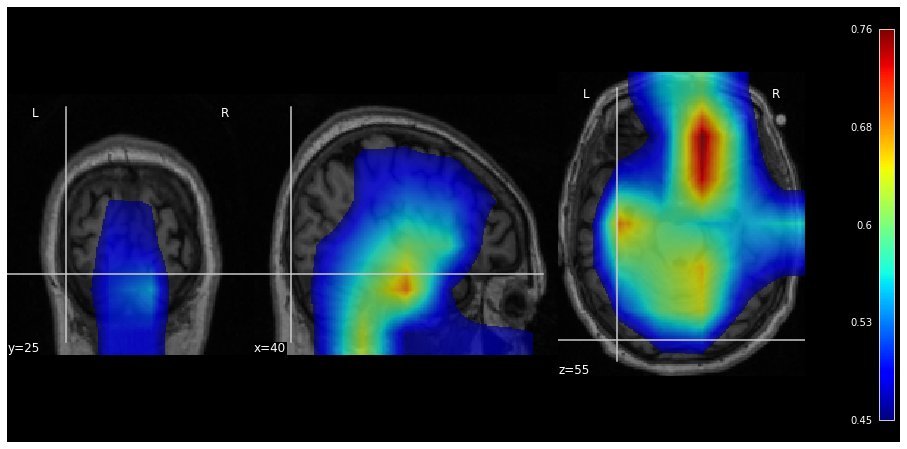

In [74]:
dataset_img = data_test.__getitem__(2)
display_interpretation(mean_1, dataset_img, threshold=0.45)


torch.Size([1, 169, 208, 179])
(169, 208, 179)


/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


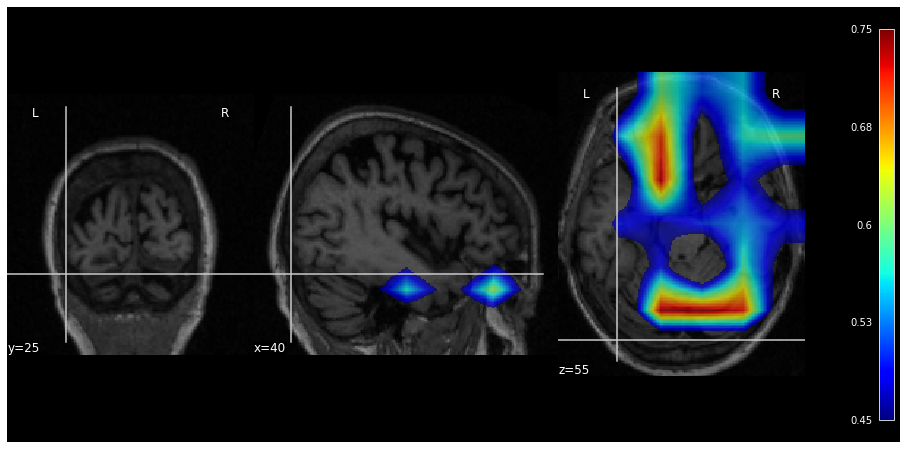

In [83]:
dataset_img = data_test.__getitem__(10)
display_interpretation(mean_0, dataset_img, threshold=0.45)

### Guided Backprop

**Idea**: using gradient back propagation as it is except at the ReLU stages. Guided Backpropagation basically combines vanilla backpropagation and DeconvNets when handling the ReLU nonlinearity:
 - Like DeconvNets, in Guided Backpropagation we only backpropagate positive error signals – i.e. we set the negative gradients to zero (ref). This is the application of the ReLU to the error signal itself during the backward pass.
 - Like vanilla backpropagation, we also restrict ourselves to only positive inputs.

Thus, the gradient is “guided” by both the input and the error signal.



In [94]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model

    def guided_backprop(self, input, label):

        def hookfunc(module, gradInput, gradOutput):
            return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])

        input.requires_grad = True
        h = [0] * len(list(self.model.features) + list(self.model.classifier))
        for i, module in enumerate(list(self.model.features) + list(self.model.classifier)):
            if type(module) == nn.ReLU:
                h[i] = module.register_backward_hook(hookfunc)

        self.model.eval()
        output = self.model(input)
        self.model.zero_grad()
        output[0][label].backward()
        grad = input.grad.data
        grad /= grad.max()
        return np.clip(grad.cpu().numpy(), 0, 1)

In [101]:
mean_0_gp, mean_1_gp = get_masks(model, test_loader, mean_mask=True, mask_type='guided_backprop',
                  size=data_test.size)

18it [01:11,  3.98s/it]


torch.Size([1, 169, 208, 179])
(169, 208, 179)


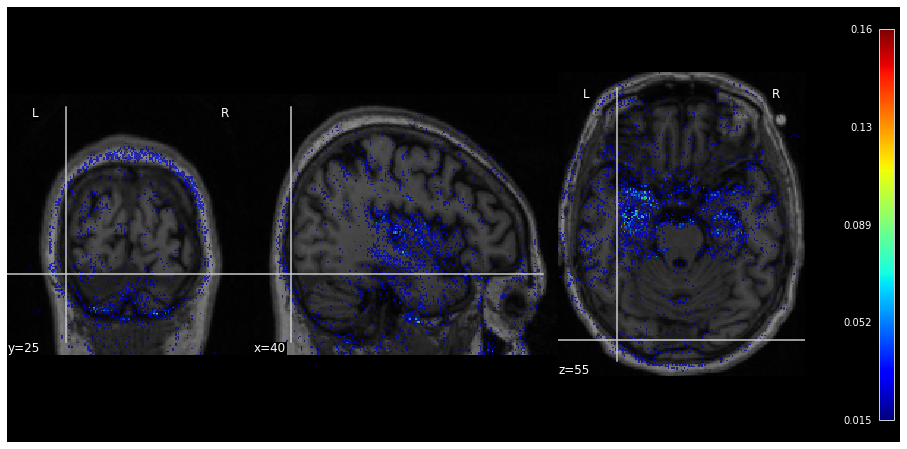

In [105]:
dataset_img = data_test.__getitem__(2)
display_interpretation(mean_1_gp, dataset_img, threshold=0.015)

torch.Size([1, 169, 208, 179])
(169, 208, 179)


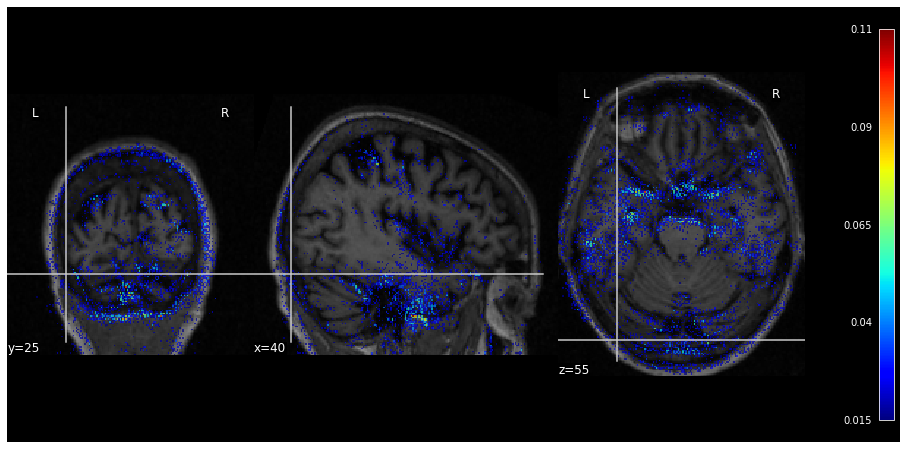

In [106]:
dataset_img = data_test.__getitem__(10)
display_interpretation(mean_0_gp, dataset_img, threshold=0.015)

MeanPertrub

In [131]:
from scipy.ndimage import gaussian_filter
from torch.optim import Adam
def jittering(img, jit, C, D, H, W):
    return np.pad(img, [(0, 0), (0, jit), (0, jit), (0, jit)], mode='constant')


def upsample(mask, img_size):
    x = F.interpolate(mask, size=img_size, mode='trilinear', align_corners=False)
    return x


def np_to_torch(X, img_size, requires_grad=False):
    output = torch.tensor(X, requires_grad=requires_grad).cuda()
    return output.reshape(img_size)


def tv_norm(x, beta=1):
    d1 = torch.mean(torch.abs(x[:, :, :-1, :, :] - x[:, :, 1:, :, :]).pow(beta))
    d2 = torch.mean(torch.abs(x[:, :, :, :-1, :] - x[:, :, :, 1:, :]).pow(beta))
    d3 = torch.mean(torch.abs(x[:, :, :, :, :-1] - x[:, :, :, :, 1:]).pow(beta))
    tv = d1 + d2 + d3
    return tv

class GaussianFilter(nn.Module):
    def __init__(self, k_size, g_filter):
        super(GaussianFilter, self).__init__()
        # self.device = device
        pad = (k_size - 1) // 2
        self.k_size = k_size
        self.conv = nn.Conv3d(1, 1, k_size, padding=(pad, pad, pad), bias=None)
        self.conv.cuda()
        self.g_filter = g_filter

    def forward(self, x, sigma):
        n = np.zeros((self.k_size, self.k_size, self.k_size))
        n[self.k_size // 2 + 1, self.k_size // 2 + 1, self.k_size // 2 + 1] = 1
        k = self.g_filter(n, sigma=sigma)[None, None, :, :, :]
        self.conv.weight = torch.nn.Parameter(torch.from_numpy(k).float().cuda())
        for param in self.conv.parameters():
            param.requires_grad = False
        return self.conv(x)


class MeanPertrub():
    def __init__(self, mask_scale=4, blur_img=10, blur_mask=10, max_iter=300,
                 l1_coef=3, tv_coef=1, tv_beta=7, rep=10, jit=5, k_size=5, lr=1e-4):
        # self.device = device
        self.lr = lr
        self.mask_scale = 4
        self.blur_img = blur_img
        self.blur_mask = blur_mask
        self.max_iter = max_iter
        self.l1_coef = l1_coef
        self.tv_coef = tv_coef
        self.tv_beta = tv_beta
        self.rep = rep
        self.jit = jit
        self.filter_gaus = GaussianFilter(k_size, gaussian_filter)

    def get_masks(self, img, pred, model):
        res = []
        rw_max = self.max_iter // 5
        i = 0
        img = img.squeeze(axis=0)
        C, D, H, W = img.shape
        model_ans = pred
        mask = torch.ones((1, C, D // self.mask_scale, H // self.mask_scale, W // self.mask_scale),
                          requires_grad=True, device='cuda')
        optimizer = Adam([mask], lr=self.lr, betas=(0.9, 0.99), amsgrad=True, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_loss, best_mask = float('inf'), None
        for epoch in tqdm(range(self.max_iter)):
            mask_up = upsample(mask, img_size=(D, H, W))
            mask_up = self.filter_gaus(mask_up, self.blur_mask)
            total_pred_loss = 0
            for _ in range(self.rep):
                img_jit = jittering(img.cpu(), self.jit, C, D, H, W)
                j0 = np.random.randint(self.jit)
                j1 = np.random.randint(self.jit)
                j2 = np.random.randint(self.jit)
                img_jit = img_jit[:, j0:(D + j0), j1:(H + j1), j2:(W + j2)]
                img_torch = np_to_torch(img_jit, img_size=(1, C, D, H, W), requires_grad=False)
                blur = self.filter_gaus(img_torch, self.blur_img)
                perturbated_input = img_torch.mul(mask_up) + blur.mul(1 - mask_up).cuda()
                outputs = model(perturbated_input.float())  # problem
                prob = torch.exp(outputs)
                total_pred_loss += F.relu(prob[0, model_ans] - 0.05)
                del outputs, prob, perturbated_input, blur, img_torch, img_jit
            reg_loss = self.l1_coef * torch.mean(torch.abs(1 - mask)) + self.tv_coef * tv_norm(mask_up,
                                                                                               self.tv_beta)
            rw = 1 if epoch > rw_max else epoch / rw_max
            loss = total_pred_loss / self.rep + rw * reg_loss
            
            if epoch > 50 and loss.item() <= best_loss:
                best_loss = loss.item()
                best_mask = mask.clone().detach()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            mask.data.clamp_(0, 1)

        res_mask = upsample((1 - best_mask), img_size=(D, H, W))
        res.append(res_mask.cpu().numpy())
        i += 1
        return res_mask.cpu().numpy()

In [ ]:
mean_0_mp, mean_1_mp = get_masks(model, test_loader, mean_mask=True, mask_type='mean_pertrub',
                  size=data_test.size)

0it [00:00, ?it/s]
100%|██████████| 300/300 [13:06<00:00,  2.62s/it]
1it [13:07, 787.23s/it]
100%|██████████| 300/300 [13:04<00:00,  2.61s/it]
2it [26:12, 786.03s/it]
100%|██████████| 300/300 [13:03<00:00,  2.61s/it]
3it [39:16, 785.20s/it]
100%|██████████| 300/300 [13:06<00:00,  2.62s/it]
4it [52:24, 786.07s/it]
100%|██████████| 300/300 [13:06<00:00,  2.62s/it]
5it [1:05:32, 786.78s/it]
100%|██████████| 300/300 [13:06<00:00,  2.62s/it]
6it [1:18:39, 787.12s/it]
100%|██████████| 300/300 [13:01<00:00,  2.60s/it]
7it [1:31:42, 785.61s/it]
100%|██████████| 300/300 [12:59<00:00,  2.60s/it]
8it [1:44:43, 784.03s/it]
100%|██████████| 300/300 [13:01<00:00,  2.60s/it]
9it [1:57:45, 783.54s/it]
100%|██████████| 300/300 [12:59<00:00,  2.60s/it]
10it [2:10:45, 782.57s/it]
100%|██████████| 300/300 [13:02<00:00,  2.61s/it]
11it [2:23:49, 782.80s/it]
 12%|█▏        | 35/300 [01:30<11:29,  2.60s/it]

In [ ]:
m_ad =  'drive/MyDrive/neuro_2021/sub-ADNI009S1354_ses-M00_T1_mean_pertrub_mean_1_test.nii.gz'
meanp_ad = nib.load(m_ad)
dataset_img = data_test.__getitem__(2)

In [ ]:
fig, axes = plt.subplots(figsize=(16, 8))

# roi_img = nib.Nifti1Image(interp_img, affine=np.eye(4))
bim_img = nib.Nifti1Image(np.squeeze(dataset_img['image']).cpu().detach().numpy(), affine=np.eye(4))
plotting.plot_roi(meanp_ad,bim_img, axes=axes, colorbar=True, cmap='jet', threshold=0.35, title='AD')
plt.show()